In [1]:
# TODO: connect code cell to table (write table number in every cell)

In [21]:
import pandas as pd
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
import re
embedding_model = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_enwiki_20180420_nolg_100d", filename="enwiki_20180420_nolg_100d.txt"))
pd.options.display.max_colwidth = 2000

In [3]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [4]:
dataset = load_dataset("xsum")
scores_path = r"eval_scores_xsum_summaries.csv"
fact_path = r"factuality_annotations_xsum_summaries.csv"
hallu_path = r"hallucination_annotations_xsum_summaries.csv"
scores_df = pd.read_csv(scores_path)
fact_df = pd.read_csv(fact_path)
hallu_df = pd.read_csv(hallu_path)

In [5]:
"""
creating a DataFrame with the text, the reference summary and the model summary, together
with the factual annotations
"""
bbcids = scores_df['system_bbcid'].apply(lambda bbcid: re.findall('.*_(\d+)', bbcid)[0])
bbcids = bbcids.tolist()
annotated_dataset = dataset['test'].filter(lambda sample: sample['id'] in bbcids)
annotated_df = annotated_dataset.to_pandas()
annotated_df['id'] = annotated_df['id'].apply(int)
fact_annotated_df = fact_df.merge(right=annotated_df, left_on='bbcid', right_on='id')
fact_annotated_df = fact_annotated_df.rename(columns=
                                             {'summary_x': 'model_summary',
                                              'summary_y': 'ref',
                                              'system': 'model',
                                             }).drop(columns='id')

In [6]:
"""
creating a DataFrame with the text, the reference summary and the model summary, together
with the halluciantion annotations
"""
bbcids = scores_df['system_bbcid'].apply(lambda bbcid: re.findall('.*_(\d+)', bbcid)[0])
bbcids = bbcids.tolist()
annotated_dataset = dataset['test'].filter(lambda sample: sample['id'] in bbcids)
annotated_df = annotated_dataset.to_pandas()
annotated_df['id'] = annotated_df['id'].apply(int)
hallu_annotated_df = hallu_df.merge(right=annotated_df, left_on='bbcid', right_on='id')
hallu_annotated_df = hallu_annotated_df.rename(columns=
                                             {'summary_x': 'model_summary',
                                              'summary_y': 'ref',
                                              'system': 'model',
                                             }).drop(columns='id')

In [7]:
"""
create the DataFrame with the text and summaries, together with ROUGE metrics
Note: this might take a while
"""
rouge = evaluate.load('rouge')
lines = []
num_examples = len(fact_annotated_df)
# num_examples = len(hallu_annotated_df)
df = fact_annotated_df
col_name = 'is_factual'
# df = hallu_annotated_df
# col_name = 'is_hallucination'
for i in range(num_examples):
    sample = df.iloc[i]
    sample_id, model, text, ref_summary, model_summary, col = sample['bbcid'], sample['model'], sample['document'], sample['ref'], sample['model_summary'], sample[col_name]
    ref_results_dict = rouge.compute(predictions=[model_summary], references=[ref_summary])
    text_results_dict = rouge.compute(predictions=[model_summary], references=[text])
    text_ref_results_dict = rouge.compute(predictions=[ref_summary], references=[text])
    line = [sample_id, model, text, ref_summary, model_summary, col,
            *list(ref_results_dict.values()),
            *list(text_results_dict.values()),
            *list(text_ref_results_dict.values())]
    lines.append(line)
    if i % 50 == 0:
        print(f'DONE {i}/{num_examples}')
rouge_df = pd.DataFrame(columns=['id', 'model', 'text', 'ref_summary', 'model_summary', col_name,
                                   'ref_R1', 'ref_R2', 'ref_RL', 'ref_RLSum',
                          'text_R1', 'text_R2', 'text_RL', 'text_RLSum',
                          'text_ref_R1', 'text_ref_R2', 'text_ref_RL', 'text_ref_RLSum'],
                 data=lines)

DONE 0/5576
DONE 50/5576
DONE 100/5576
DONE 150/5576
DONE 200/5576
DONE 250/5576
DONE 300/5576
DONE 350/5576
DONE 400/5576
DONE 450/5576
DONE 500/5576
DONE 550/5576
DONE 600/5576
DONE 650/5576
DONE 700/5576
DONE 750/5576
DONE 800/5576
DONE 850/5576
DONE 900/5576
DONE 950/5576
DONE 1000/5576
DONE 1050/5576
DONE 1100/5576
DONE 1150/5576
DONE 1200/5576
DONE 1250/5576
DONE 1300/5576
DONE 1350/5576
DONE 1400/5576
DONE 1450/5576
DONE 1500/5576
DONE 1550/5576
DONE 1600/5576
DONE 1650/5576
DONE 1700/5576
DONE 1750/5576
DONE 1800/5576
DONE 1850/5576
DONE 1900/5576
DONE 1950/5576
DONE 2000/5576
DONE 2050/5576
DONE 2100/5576
DONE 2150/5576
DONE 2200/5576
DONE 2250/5576
DONE 2300/5576
DONE 2350/5576
DONE 2400/5576
DONE 2450/5576
DONE 2500/5576
DONE 2550/5576
DONE 2600/5576
DONE 2650/5576
DONE 2700/5576
DONE 2750/5576
DONE 2800/5576
DONE 2850/5576
DONE 2900/5576
DONE 2950/5576
DONE 3000/5576
DONE 3050/5576
DONE 3100/5576
DONE 3150/5576
DONE 3200/5576
DONE 3250/5576
DONE 3300/5576
DONE 3350/5576
DON

In [8]:
"""
filter samples with high rouge scores
"""
th = 0.5
hs_df = rouge_df[rouge_df['ref_R1']>=th]
# hs_df[col].value_counts()

In [24]:
def evaluate(bad_indices, good_indices, r1_scores, our_scores):
    eval_score = 0
    for i in range(len(bad_indices)):
        sample_score = r1_scores[i] - our_scores[i]
        eval_score += sample_score
    for i in range(len(bad_indices), len(bad_indices) + len(good_indices)):
        sample_score = our_scores[i] - r1_scores[i]
        eval_score += sample_score
    return eval_score

def evaluate_avg(bad_indices, good_indices, r1_scores, our_scores):
    bad_eval_score = 0
    good_eval_score = 0
    for i in range(len(bad_indices)):
        sample_score = r1_scores[i] - our_scores[i]
        bad_eval_score += sample_score
    for i in range(len(bad_indices), len(bad_indices) + len(good_indices)):
        sample_score = r1_scores[i] - our_scores[i]
        good_eval_score += sample_score
    return bad_eval_score / len(bad_indices) - good_eval_score / len(good_indices)

In [22]:
def get_max_sim_score(words: list, text: list):
    def norm(vec: np.ndarray):
        vec_norm = np.linalg.norm(vec)
        if vec_norm > 0:
            return vec / vec_norm
        return vec
    
    def get_vector(w: str, norm=False):
        try:
            vec = embedding_model.get_vector(w.lower(), norm=norm)
        except KeyError as e:
            d = len(embedding_model.get_vector('hello'))
            vec = np.zeros(d)
        return vec
    vec = np.concatenate([get_vector(tokenize_word(w)) for w in words])
    vec = norm(vec)
    n = len(words)
    max_sim_score = 0
    for i in range(len(text)-n+1):
        text_vec = np.concatenate([get_vector(tokenize_word(w)) for w in text[i: i+n]])
        text_vec = norm(text_vec)
        sim_score = np.inner(vec, text_vec)
        max_sim_score = max(max_sim_score, sim_score)
    return max_sim_score

def get_n_gram_score(model_summary: str, text: str, n: int):
    model_summary_words_list = tokenizer.tokenize(model_summary.lower())
    text_words_list = tokenizer.tokenize(text.lower())
    sim_cnt = 0
    for i in range(len(model_summary_words_list)-n+1):
        sim_score = get_max_sim_score(model_summary_words_list[i:i+n], text_words_list)
        sim_cnt += sim_score
    return sim_cnt / max((len(model_summary_words_list)-n+1), 1)

def tokenize_word(word: str):
    tokens = tokenizer.tokenize(word.lower())
    if len(tokens) == 1:
        return tokens[0]
    elif len(tokens) == 0:
        print(f'{word} had {len(tokens)} tokens')
        return ''
    else:
        print(f'{word} had {len(tokens)} tokens: {tokens}')
        return ''

In [11]:
"""
examples of hand picked good and bad samples as shown in Table 1
"""
bad_number_indices = [705, 4980, 2221, 3139, 790]
bad_other_indices = [783, 4641, 1352, 3055, 1666]
good_samples_indices = [702, 780, 776, 1531, 5564]
cols = ['id', 'ref_summary', 'model_summary', 'ref_R1']
good_bad_examples_df = rouge_df.loc[[705, 1666, 776]][cols]
good_bad_examples_df

,id,ref_summary,model_summary,ref_R1
705,34032798,A nine-year-old boy is being treated in hospital after being hit by a vehicle in North Lanarkshire on Saturday.,a four-year-old boy is being treated in hospital after being hit by a car in north lanarkshire.,0.850000
1666,36462386,"A farmer told to demolish a mock Tudor castle that was built without planning permission has vowed to rebuild ""the work of art"" elsewhere.",a farmer who built a mock-tudor castle without planning permission has failed to demolish his mock-tudor castle.,0.604651
776,36880863,A famous white humpback whale has been spotted on his annual migration to Australia's north.,a humpback whale has been spotted off the coast of australia's north coast.,0.600000


In [12]:
# The following cells show the text overlap method results

In [18]:
"""
evaluation for text overlap (factual)
returns a df with the experiment results
"""
hs_df = rouge_df[rouge_df['ref_R1']>=0.45]
bad_indices = hs_df[hs_df['is_factual']=='no'].index.tolist()
good_indices = hs_df[hs_df['is_factual']=='yes'].index.tolist()
indices = bad_indices + good_indices
f = lambda model_ref_s, reg_score: model_ref_s * (reg_score ** 0.5)
r1_scores = []
r2_scores = []
rL_scores = []
unigram_r1_scores = []
unigram_r2_scores = []
unigram_rL_scores = []
bigram_r1_scores = []
bigram_r2_scores = []
bigram_rL_scores = []
for sample_idx in indices:
    line = hs_df.loc[sample_idx]
    text = tokenizer.tokenize(line['text'].lower())
    model_summary = tokenizer.tokenize(line['model_summary'].lower())
    
    r1_scores.append(line['ref_R1'])
    r2_scores.append(line['ref_R1'])
    rL_scores.append(line['ref_R1'])
    
    unigram_score = np.mean([tokenize_word(word) in text
                             for word in model_summary])
    line_tuples = [(tokenize_word(word), tokenize_word(next_word))
                   for word, next_word in zip(text[:-1], text[1:])]
    bigram_score = np.mean([(tokenize_word(word), tokenize_word(next_word)) in line_tuples 
                            for word, next_word in zip(model_summary[:-1], model_summary[1:])])
    
    unigram_r1_scores.append(f(line['ref_R1'], unigram_score))
    unigram_r2_scores.append(f(line['ref_R2'], unigram_score))
    unigram_rL_scores.append(f(line['ref_RL'], unigram_score))
    
    bigram_r1_scores.append(f(line['ref_R1'], bigram_score))
    bigram_r2_scores.append(f(line['ref_R2'], bigram_score))
    bigram_rL_scores.append(f(line['ref_RL'], bigram_score))

# avg evaluation
r1_unigram_avg_eval_score = evaluate_avg(bad_indices, good_indices, r1_scores, unigram_r1_scores)
r2_unigram_avg_eval_score = evaluate_avg(bad_indices, good_indices, r2_scores, unigram_r2_scores)
rL_unigram_avg_eval_score = evaluate_avg(bad_indices, good_indices, rL_scores, unigram_rL_scores)
r1_bigram_avg_eval_score = evaluate_avg(bad_indices, good_indices, r1_scores, bigram_r1_scores)
r2_bigram_avg_eval_score = evaluate_avg(bad_indices, good_indices, r2_scores, bigram_r2_scores)
rL_bigram_avg_eval_score = evaluate_avg(bad_indices, good_indices, rL_scores, bigram_rL_scores)

# random evaluation
random_norm_factor = 1000
r1_unigram_eval_score = 0
r2_unigram_eval_score = 0
rL_unigram_eval_score = 0
r1_bigram_eval_score = 0
r2_bigram_eval_score = 0
rL_bigram_eval_score = 0
for i in range(random_norm_factor):
    random_bad_indices = np.random.randint(low=0, high=len(bad_indices), size=len(good_indices)).tolist()
    random_indices = random_bad_indices + list(range(len(bad_indices), len(indices)))
    r1_unigram_eval_score += evaluate(random_bad_indices, good_indices, [r1_scores[idx] for idx in random_indices],
                                     [unigram_r1_scores[idx] for idx in random_indices])
    r2_unigram_eval_score += evaluate(random_bad_indices, good_indices, [r2_scores[idx] for idx in random_indices],
                                     [unigram_r2_scores[idx] for idx in random_indices])
    rL_unigram_eval_score += evaluate(random_bad_indices, good_indices, [rL_scores[idx] for idx in random_indices],
                                     [unigram_rL_scores[idx] for idx in random_indices])
    r1_bigram_eval_score += evaluate(random_bad_indices, good_indices, [r1_scores[idx] for idx in random_indices],
                                    [bigram_r1_scores[idx] for idx in random_indices])
    r2_bigram_eval_score += evaluate(random_bad_indices, good_indices, [r2_scores[idx] for idx in random_indices],
                                    [bigram_r2_scores[idx] for idx in random_indices])
    rL_bigram_eval_score += evaluate(random_bad_indices, good_indices, [rL_scores[idx] for idx in random_indices],
                                    [bigram_rL_scores[idx] for idx in random_indices])
r1_unigram_eval_score /= random_norm_factor
r2_unigram_eval_score /= random_norm_factor
rL_unigram_eval_score /= random_norm_factor
r1_bigram_eval_score /= random_norm_factor
r2_bigram_eval_score /= random_norm_factor
rL_bigram_eval_score /= random_norm_factor

data = [
    ('R1', 'unigram', 'random', r1_unigram_eval_score),
    ('R1', 'unigram', 'avg', r1_unigram_avg_eval_score),
    ('R1', 'bigram', 'random', r1_bigram_eval_score),
    ('R1', 'bigram', 'avg', r1_bigram_avg_eval_score),
    ('R2', 'unigram', 'random', r2_unigram_eval_score),
    ('R2', 'unigram', 'avg', r2_unigram_avg_eval_score),
    ('R2', 'bigram', 'random', r2_bigram_eval_score),
    ('R2', 'bigram', 'avg', r2_bigram_avg_eval_score),
    ('RL', 'unigram', 'random', rL_unigram_eval_score),
    ('RL', 'unigram', 'avg', rL_unigram_avg_eval_score),
    ('RL', 'bigram', 'random', rL_bigram_eval_score),
    ('RL', 'bigram', 'avg', rL_bigram_avg_eval_score),
]

df = pd.DataFrame(columns=['Rouge Metric', 'n-gram', 'Evaluation', 'Score'], data=data)
df

,Rouge Metric,n-gram,Evaluation,Score
0,R1,unigram,random,0.179126
1,R1,unigram,avg,0.000864
2,R1,bigram,random,-2.615781
3,R1,bigram,avg,-0.015463
4,R2,unigram,random,-0.765122
5,R2,unigram,avg,-0.004441
6,R2,bigram,random,-3.033834
7,R2,bigram,avg,-0.017724
8,RL,unigram,random,1.746737
9,RL,unigram,avg,0.009918


In [19]:
"""
Average Evaluation, text overlap factual
"""
bad_indices = [705, 4980, 2221, 783, 4641]
good_indices = [702, 780, 776, 1531, 5564]
indices = bad_indices + good_indices
f = lambda model_ref_s, reg_score: model_ref_s * (reg_score ** 0.5)
data = []
for i, sample_idx in enumerate(indices):
    line = rouge_df.loc[sample_idx]
    text = tokenizer.tokenize(line['text'].lower())
    model_summary = tokenizer.tokenize(line['model_summary'].lower())
    
    unigram_score = np.mean([tokenize_word(word) in text
                             for word in model_summary])
    line_tuples = [(tokenize_word(word), tokenize_word(next_word))
                   for word, next_word in zip(text[:-1], text[1:])]
    bigram_score = np.mean([(tokenize_word(word), tokenize_word(next_word)) in line_tuples 
                            for word, next_word in zip(model_summary[:-1], model_summary[1:])])
    
    unigram_r1_score = f(line['ref_R1'], unigram_score)
    
    bigram_r1_score = f(line['ref_R1'], bigram_score)
    
    if i < 5:
        classification = 'bad'
    else:
        classification = 'good'
    
    data.append((line['id'], classification, 'unigram', line['ref_R1'] - unigram_r1_score))
    data.append((line['id'], classification, 'bigram', line['ref_R1'] - bigram_r1_score))

df = pd.DataFrame(columns=['BBCID', 'Classification', 'n-gram', 'Penalty'], data=data)
avg_sample_df = df.groupby(by=['Classification', 'n-gram']).mean()[['Penalty']].rename(columns={'Penalty': 'Average Penalty'})
avg_sample_df

Average Penalty
Classification n-gram                  
bad            bigram          0.454958
               unigram         0.142650
good           bigram          0.367865
               unigram         0.104990

In [ ]:
# The following cells show the semantic method results

1-gram done with p=0.5
1-gram done with p=1.0
1-gram done with p=1.5
1-gram done with p=2.0
2-gram done with p=0.5
2-gram done with p=1.0
2-gram done with p=1.5
2-gram done with p=2.0
3-gram done with p=0.5
3-gram done with p=1.0
3-gram done with p=1.5
3-gram done with p=2.0
4-gram done with p=0.5
4-gram done with p=1.0
4-gram done with p=1.5
4-gram done with p=2.0


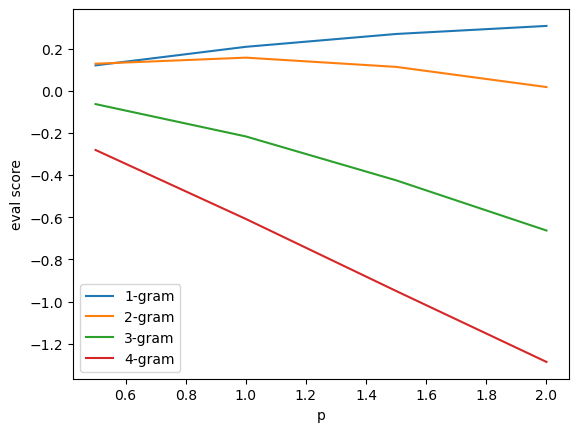

In [25]:
"""
Evaluation of model summary against text using random samples for bad indices
Regular eval function (not avg)
"""
hs_df = rouge_df[rouge_df['ref_R1']>=0.45]
good_indices = hs_df[hs_df['is_factual']=='yes'].index.tolist()
bad_indices = hs_df[hs_df['is_factual']=='no'].sample(len(good_indices)).index.tolist()
indices = bad_indices + good_indices
max_n_gram = 4
n_grams = range(1, max_n_gram+1)
powers = np.linspace(0.5, 2, 4)
for n in n_grams:
    power_evaluation_scores = []
    for p in powers:
        r1_scores = []
        n_gram_scores = []
        f = lambda model_ref_s, reg_score: model_ref_s * pow(reg_score, p)
        for sample_idx in indices:
            line = hs_df.loc[sample_idx]
            r1_scores.append(line['ref_R1'])
            n_gram_scores.append(f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['text'], n=n))) 
        print(f'{n}-gram done with p={p}')
        power_evaluation_scores.append(evaluate(bad_indices, good_indices,
                                                    r1_scores, n_gram_scores))
    plt.plot(powers, power_evaluation_scores, label=f'{n}-gram')
plt.legend()
plt.xlabel('p')
plt.ylabel('eval score')
plt.show()

1-gram done with p=0.5
1-gram done with p=1.0
1-gram done with p=1.5
1-gram done with p=2.0
2-gram done with p=0.5
2-gram done with p=1.0
2-gram done with p=1.5
2-gram done with p=2.0
3-gram done with p=0.5
3-gram done with p=1.0
3-gram done with p=1.5
3-gram done with p=2.0
4-gram done with p=0.5
4-gram done with p=1.0
4-gram done with p=1.5
4-gram done with p=2.0


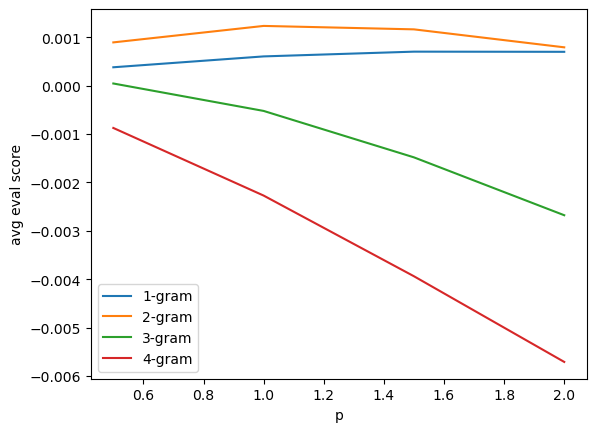

In [26]:
"""
Evaluation of model summary against text using average eval.
"""
hs_df = rouge_df[rouge_df['ref_R1']>=0.45]
bad_indices = hs_df[hs_df['is_factual']=='no'].index.tolist()
good_indices = hs_df[hs_df['is_factual']=='yes'].index.tolist()
indices = bad_indices + good_indices
max_n_gram = 4
n_grams = range(1, max_n_gram+1)
powers = np.linspace(0.5, 2, 4)
for n in n_grams:
    power_evaluation_scores = []
    for p in powers:
        r1_scores = []
        n_gram_scores = []
        f = lambda model_ref_s, reg_score: model_ref_s * pow(reg_score, p)
        for sample_idx in indices:
            line = hs_df.loc[sample_idx]
            r1_scores.append(line['ref_R1'])
            n_gram_scores.append(f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['text'], n=n))) 
        print(f'{n}-gram done with p={p}')
        power_evaluation_scores.append(evaluate_avg(bad_indices, good_indices,
                                                    r1_scores, n_gram_scores))
    plt.plot(powers, power_evaluation_scores, label=f'{n}-gram')
plt.legend()
plt.xlabel('p')
plt.ylabel('avg eval score')
plt.show()

1-gram done with p=0.5
1-gram done with p=1.0
1-gram done with p=1.5
1-gram done with p=2.0
2-gram done with p=0.5
2-gram done with p=1.0
2-gram done with p=1.5
2-gram done with p=2.0
3-gram done with p=0.5
3-gram done with p=1.0
3-gram done with p=1.5
3-gram done with p=2.0
4-gram done with p=0.5
4-gram done with p=1.0
4-gram done with p=1.5
4-gram done with p=2.0


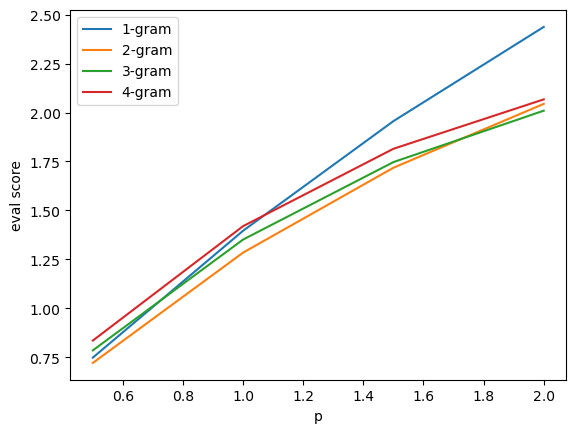

In [27]:
"""
Evaluation of model summary against reference summary using random bad samples, not avg
"""
hs_df = rouge_df[rouge_df['ref_R1']>=0.45]
good_indices = hs_df[hs_df['is_factual']=='yes'].index.tolist()
bad_indices = hs_df[hs_df['is_factual']=='no'].sample(len(good_indices)).index.tolist()
indices = bad_indices + good_indices
max_n_gram = 4
n_grams = range(1, max_n_gram+1)
powers = np.linspace(0.5, 2, 4)
for n in n_grams:
    power_evaluation_scores = []
    for p in powers:
        r1_scores = []
        n_gram_scores = []
        f = lambda model_ref_s, reg_score: model_ref_s * pow(reg_score, p)
        for sample_idx in indices:
            line = hs_df.loc[sample_idx]
            r1_scores.append(line['ref_R1'])
            n_gram_scores.append(f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['ref_summary'], n=n))) 
        print(f'{n}-gram done with p={p}')
        power_evaluation_scores.append(evaluate(bad_indices, good_indices,
                                                    r1_scores, n_gram_scores))
    plt.plot(powers, power_evaluation_scores, label=f'{n}-gram')
plt.legend()
plt.xlabel('p')
plt.ylabel('eval score')
plt.show()

1-gram done with p=0.5
1-gram done with p=1.0
1-gram done with p=1.5
1-gram done with p=2.0
2-gram done with p=0.5
2-gram done with p=1.0
2-gram done with p=1.5
2-gram done with p=2.0
3-gram done with p=0.5
3-gram done with p=1.0
3-gram done with p=1.5
3-gram done with p=2.0
4-gram done with p=0.5
4-gram done with p=1.0
4-gram done with p=1.5
4-gram done with p=2.0


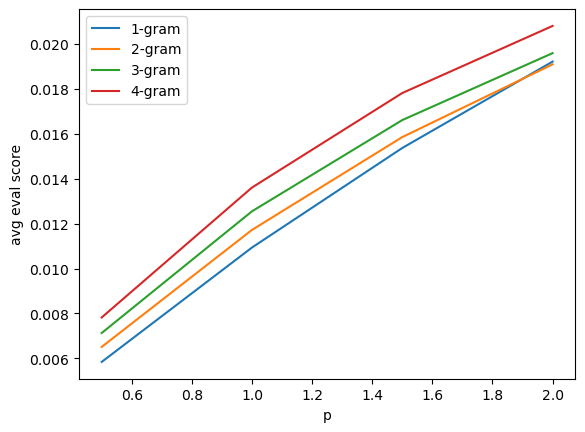

In [28]:
"""
Evaluation of model summary against reference summary using avg eval
"""
hs_df = rouge_df[rouge_df['ref_R1']>=0.45]
bad_indices = hs_df[hs_df['is_factual']=='no'].index.tolist()
good_indices = hs_df[hs_df['is_factual']=='yes'].index.tolist()
indices = bad_indices + good_indices
max_n_gram = 4
n_grams = range(1, max_n_gram+1)
powers = np.linspace(0.5, 2, 4)
for n in n_grams:
    power_evaluation_scores = []
    for p in powers:
        r1_scores = []
        n_gram_scores = []
        f = lambda model_ref_s, reg_score: model_ref_s * pow(reg_score, p)
        for sample_idx in indices:
            line = hs_df.loc[sample_idx]
            r1_scores.append(line['ref_R1'])
            n_gram_scores.append(f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['ref_summary'], n=n))) 
        print(f'{n}-gram done with p={p}')
        power_evaluation_scores.append(evaluate_avg(bad_indices, good_indices,
                                                    r1_scores, n_gram_scores))
    plt.plot(powers, power_evaluation_scores, label=f'{n}-gram')
plt.legend()
plt.xlabel('p')
plt.ylabel('avg eval score')
plt.show()

In [32]:
"""
Multiplicative evaluation of model summary against text and model summary against reference summary
on our hand picked samples
"""
bad_number_indices = [705, 4980, 2221, 3139, 790]
bad_other_indices = [783, 3055, 1666]
good_samples_indices = [702, 780, 776, 1531, 5564]
indices = bad_number_indices + bad_other_indices + good_samples_indices
data = []
powers = np.linspace(0.5, 2, 4)
max_n_gram = 4
text_data = []
ref_data = []
for n in range(1, max_n_gram + 1):
    r1_scores = []
    for i, sample_idx in enumerate(indices):
        line = rouge_df.loc[sample_idx]
        r1_scores.append(line['ref_R1'])
        classification = 'bad' if i < (len(bad_number_indices) + len(bad_other_indices)) else 'good'
        text_row = [n, classification]
        ref_row = [n, classification]
        for p in powers:
            f = lambda model_ref_s, reg_score: model_ref_s * (reg_score ** p)
            eval_text_score = line['ref_R1'] - f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                        line['text'], n=n))
            eval_ref_score = line['ref_R1'] - f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                        line['ref_summary'], n=n))
            text_row.append(eval_text_score)
            ref_row.append(eval_ref_score)
        text_data.append(text_row)
        ref_data.append(ref_row)
text_df = pd.DataFrame(columns=['n-gram', 'Classification', 'Eval Score p=0.5', 'Eval Score p=1',
                                'Eval Score p=1.5', 'Eval Score p=2'], data=text_data)
ref_df = pd.DataFrame(columns=['n-gram', 'Classification', 'Eval Score p=0.5', 'Eval Score p=1',
                                'Eval Score p=1.5', 'Eval Score p=2'], data=ref_data)
avg_text_df = text_df.groupby(by=['Classification', 'n-gram']).mean()[['Eval Score p=0.5', 'Eval Score p=1',
                                'Eval Score p=1.5', 'Eval Score p=2']].rename(
    columns={'Eval Score p=0.5': 'Average Eval Score p=0.5',
            'Eval Score p=1': 'Average Eval Score p=1',
            'Eval Score p=1.5': 'Average Eval Score p=1.5',
            'Eval Score p=2': 'Average Eval Score p=2'})
avg_ref_df = ref_df.groupby(by=['Classification', 'n-gram']).mean()[['Eval Score p=0.5', 'Eval Score p=1',
                                'Eval Score p=1.5', 'Eval Score p=2']].rename(
    columns={'Eval Score p=0.5': 'Average Eval Score p=0.5',
            'Eval Score p=1': 'Average Eval Score p=1',
            'Eval Score p=1.5': 'Average Eval Score p=1.5',
            'Eval Score p=2': 'Average Eval Score p=2'})
avg_ref_df

Average Eval Score p=0.5  Average Eval Score p=1  \
Classification n-gram                                                     
bad            1                       0.019850                0.038773   
               2                       0.030565                0.058894   
               3                       0.037595                0.071733   
               4                       0.043021                0.081356   
good           1                       0.032660                0.063487   
               2                       0.048646                0.093238   
               3                       0.059882                0.113428   
               4                       0.068674                0.128838   

                       Average Eval Score p=1.5  Average Eval Score p=2  
Classification n-gram                                                    
bad            1                       0.056818                0.074034  
               2                       0.085174                0.109579  
               3                       0.102773                0.131034  
               4                       0.115585                0.146209  
good           1                       0.092590                0.120072  
               2                       0.134138                0.171672  
               3                       0.161367                0.204343  
               4                       0.181654                0.228111

In [34]:
"""
Evaluation of the additive method, model summary against text and model summary against
reference summary
"""
hs_df = rouge_df[rouge_df['ref_R1']>=0.45]
bad_indices = hs_df[hs_df['is_factual']=='no'].index.tolist()
good_indices = hs_df[hs_df['is_factual']=='yes'].index.tolist()
indices = bad_indices + good_indices
f = lambda model_ref_s, reg_score: model_ref_s + reg_score
max_n_gram = 4
data = []
for n in range(1, max_n_gram + 1):
    r1_scores = []
    n_gram_text_scores = []
    n_gram_ref_scores = []
    for sample_idx in indices:
        line = hs_df.loc[sample_idx]
        r1_scores.append(line['ref_R1'])
        n_gram_text_scores.append(f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['text'], n=n))) 
        n_gram_ref_scores.append(f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['ref_summary'], n=n)))
    text_avg_eval = evaluate_avg(bad_indices, good_indices, r1_scores, n_gram_text_scores)
    ref_avg_eval = evaluate_avg(bad_indices, good_indices, r1_scores, n_gram_ref_scores)
    random_norm_factor = 1000
    regular_eval_text_score = 0
    regular_eval_ref_score = 0
    for i in range(random_norm_factor):
        random_bad_indices = np.random.randint(low=0, high=len(bad_indices), size=len(good_indices)).tolist()
        random_indices = random_bad_indices + list(range(len(bad_indices), len(indices)))
        regular_eval_text_score += evaluate(random_bad_indices, good_indices, [r1_scores[idx] for idx in random_indices],
                                         [n_gram_text_scores[idx] for idx in random_indices])
        regular_eval_ref_score += evaluate(random_bad_indices, good_indices, [r1_scores[idx] for idx in random_indices],
                                         [n_gram_ref_scores[idx] for idx in random_indices])
    regular_eval_text_score /= random_norm_factor
    regular_eval_ref_score /= random_norm_factor
    
    data.append((n, 'regular', regular_eval_text_score, regular_eval_ref_score))
    data.append((n, 'average', text_avg_eval, ref_avg_eval))
    print(f"done with {n}-gram")

df = pd.DataFrame(columns=['n-gram', 'Evaluation Type', 'Text Score', 'Reference Score'], data=data)
df

done with 1-gram
done with 2-gram
done with 3-gram
done with 4-gram


,n-gram,Evaluation Type,Text Score,Reference Score
0,1,regular,1.825432,3.683180
1,1,average,0.010730,0.021324
2,2,regular,2.770397,4.040497
3,2,average,0.016179,0.023389
4,3,regular,2.738807,4.342107
5,3,average,0.015758,0.025308
6,4,regular,2.485824,4.708741
7,4,average,0.014552,0.027249


In [35]:
"""
Evaluation of the additive method, model summary against text and model summary against
reference summary on our hand picked samples
"""
bad_number_indices = [705, 4980, 2221, 3139, 790]
bad_other_indices = [783, 3055, 1666]
good_samples_indices = [702, 780, 776, 1531, 5564]
indices = bad_number_indices + bad_other_indices + good_samples_indices
data = []
max_n_gram = 4
for n in range(1, max_n_gram + 1):
    print(f"{n}-gram DONE")
    r1_scores = []
    for i, sample_idx in enumerate(indices):
        line = rouge_df.loc[sample_idx]
        r1_scores.append(line['ref_R1'])
        classification = 'bad' if i < (len(bad_number_indices) + len(bad_other_indices)) else 'good'
        row = [n, classification]
        eval_text_score = f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['text'], n=n)) - line['ref_R1']
        eval_ref_score =  f(line['ref_R1'], get_n_gram_score(line['model_summary'],
                                                                    line['ref_summary'], n=n)) - line['ref_R1']
        row.extend([eval_text_score, eval_ref_score])
        data.append(row)
df = pd.DataFrame(columns=['n-gram', 'Classification', 'Eval Text', 'Eval Reference'], data=data)
grouped_df = df.groupby(by=['Classification', 'n-gram']).mean().rename(
    columns={'Eval Text': 'Avg Eval Text',
             'Eval Reference': 'Avg Eval Reference'})
grouped_df

1-gram DONE
2-gram DONE
3-gram DONE
4-gram DONE


Avg Eval Text  Avg Eval Reference
Classification n-gram                                   
bad            1            0.866382            0.937897
               2            0.747760            0.906527
               3            0.690952            0.885912
               4            0.652256            0.870062
good           1            0.912017            0.896758
               2            0.816025            0.847624
               3            0.752103            0.813595
               4            0.702977            0.787574